# Measurement of a 1D Profil


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from main import measure
from helper import view, view_phase
import numba_ft

# Setup
## Load the sample2
This time the sample consists of two sub-samples with different $T_1$ and $T_2$.
They resemble oil and water. 
Two different versions of sample2 can be loaded. 
1. `sample2.npy` Size $100 \times 100$  
2. `sample2_modi.npy`Size $300 \times 300$  
The second one takes a lot longer to simulate but the result resembles the reality far better.
In this notebook the second one will be used but feel free to change to the first one.

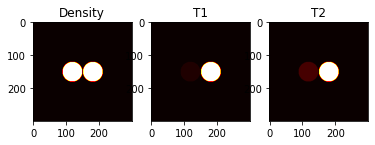

In [2]:
sample = np.load(f"{os.getcwd()}/sample2_modi.npy")
view(sample)

## Setup magnetic field
It is necessary to add some noise to the magnetic field. Otherwise, the magnetic
field will be perfectly homogenous, which is unrealistic. Furthermore, is a slight
inhomogeneity in the magnetic field necessary for spin echos.

In [3]:
b0 = np.zeros(sample.shape[:2])
b0.fill(0.43)
b0 += np.random.normal(0, 0.001, b0.shape)

Setup phases and measurement time

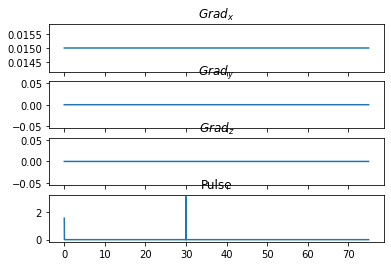

In [4]:
tfactor = 1000  # how many steps per 1ms
t = 75
echotime = 30

# phases = [Gradx, Grady, Gradz, Pulse]
ts = np.linspace(0, t, t * tfactor, True)
phases = np.zeros((t * tfactor, 4))

# pulses
phases[0, 3] = np.pi / 2
phases[tfactor * echotime, 3] = np.pi
get = list(range(2 * tfactor * echotime - tfactor * 10, 2 * tfactor * echotime + tfactor * 10))

# gradient in x
phases[:, 0] = 0.015

view_phase(phases, tfactor)

# Measurement & Results
## Measurement with gradient along x

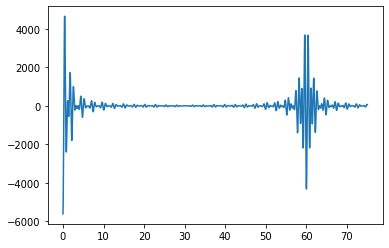

In [5]:
signal = measure(sample, b0, tfactor, phases)
plt.plot(ts, signal)
plt.show()


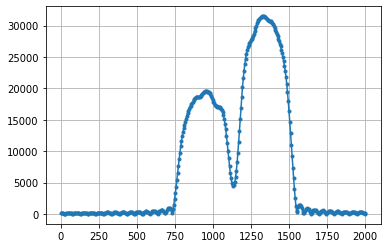

In [6]:
f = np.linspace(0, 2000, 400, True)
times = np.array([e / tfactor * 1e-3 for e in get])
fft_signal = np.abs(numba_ft.ft_uneven(signal[get], times, 2 * np.pi * f, 1, 0))
plt.plot(f, fft_signal, ".-")
plt.grid()
plt.show()

If version `sample2.npy` was used: This result is a litte bit unfortunate. It looks like two gaussian peaks.
Due to the cyclic form of the sample another result would be better. A measured
image for such a sample is shown bellow:

![image of sample](figures\1d\profile.png)

The accuracy here is limited to the size we "draw" the sample on. The created
sample has a size of $100\times100$ in total. Both circles, each have a radius of 10 array slots.
Therefore, the image is washed out.

## Measurement with gradient along y

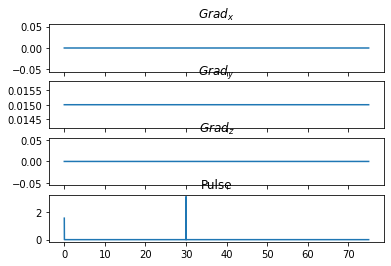

In [7]:
# remove gradient in x
phases[:, 0] = 0
# gradient in y
phases[:, 1] = 0.015
view_phase(phases, tfactor)

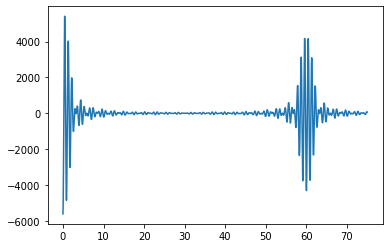

In [11]:
signal = measure(sample, b0, tfactor, phases)
plt.plot(ts, signal)
plt.show()

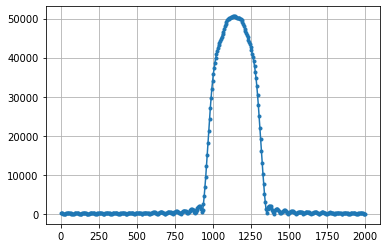

In [13]:
f = np.linspace(0, 2000, 400, True)
times = np.array([e / tfactor * 1e-3 for e in get])
fft_signal = np.abs(numba_ft.ft_uneven(signal[get], times, 2 * np.pi * f, 1, 0))
plt.plot(f, fft_signal, ".-")
plt.grid()
plt.show()

If we measure in y direction we get a single signal.
Comparing the amplitude we find an amplitude close to the sum of the amplitudes of the signals before.
This is as we expected as the spins along the x direction "feel" the same magnetic field (ignoring the noise).